# Legi: 22-942-684

# SLT-CE-2: Deterministic Annealing

### References

<ol>
<li> Sections II.A.1 (principled derivation of deterministic annealing) and II.A.3 (Mass-constrained clustering) of 'Deterministic annealing for clustering, compression, classification, regression, and related optimization problems', Kenneth Rose, 1998, http://ieeexplore.ieee.org/document/726788/ 
</li>

<li>
The wine data set, http://www3.dsi.uminho.pt/pcortez/wine5.pdf
</li>
    
</ol>

### Setup 

In [2]:
import sklearn as skl
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import sklearn.svm as svm
from sklearn import cluster

import pandas as pd
import numpy as np
from treelib import Tree

import matplotlib.pyplot as plt
from matplotlib import cm

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.0 </span>
</h2>

<p style="background-color:#adebad;">
    For this exercise, it is of utmost importance to read reference [1] about deterministic annealing clustering (DAC). Our implementation will be based on this reference. Please shortly summarize what they refer to as the <i>preferred implementation</i> of the DAC algorithm.
</p>

Put your markdown text here

1) Initialize/Set limits: number of codevectors/cluster $K_{max}$, minimum temperature $T_{min}$ 
2) Initialize: temperature T>2 \lambda_max(C_x), where C_x is the covariance matrix of the data, K=1 (number of clusters), y1= $\sum xp(x)$ (we initialize the centroid at the mean of the data), p(y1)=1
3) Update for i=1,...K
   y_i=$\frac {\sum xp(x)p(y_i|x)}{p(y_i)}$ where
   p(y_i|x)=$\frac{p(y_i)exp(-\frac{(x-y_i)^2}{T})}{\sum p(y_j)exp(-\frac{(x-y_j)^2}{T})}$
4) Convergence Test. If not satisfied go to 3) (we check if the iterative procedure for calculating the centroids actually converges)
5) If T $\leq$ $T_{min}$, perform last iteration with T=0 and terminate (last iteration with T=0 means that we are basically applying K-means in the last step. For numerical reasons, since we cannot plug in T=0 in our formulas, we choose a value of T very small)
6) Cooling step: T $\leftarrow \alpha T $ where $\alpha$<1 is the cooling parameter
7) If K<$K_{max}$, check phase transition conditions (i.e. check if critical temperature has been reached, where $T_c=2 \lambda_{max}(C_{x|y})$, where $C_{x|y}$ is the covariance of the posterior distribution p(x|y) of the cluster corresponding to codevector/centroid y. For i=1,...,K, if $T_c$ has been reached for cluster j, add new centroid with $y_{K+1}=y_j+\delta$, $p_{K+1}(y_j)=\frac{p(y_j)}{2}$, $p(y_j) \leftarrow \frac{p(y_j)}{2}$, increase K by 1
8) Go back to 3)

<p style="background-color:#adebad;">
    In order to avoid headaches with numerical instabilities, we first try our algorithm on a simple artificially generated data as below. Run the bloc below to have a look at the data. Later when we have everything implemented, we will examine some real world data. 
</p>

Text(0.5, 1.0, 'Test data')

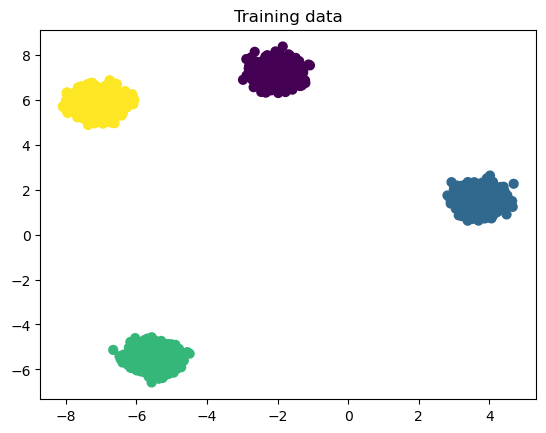

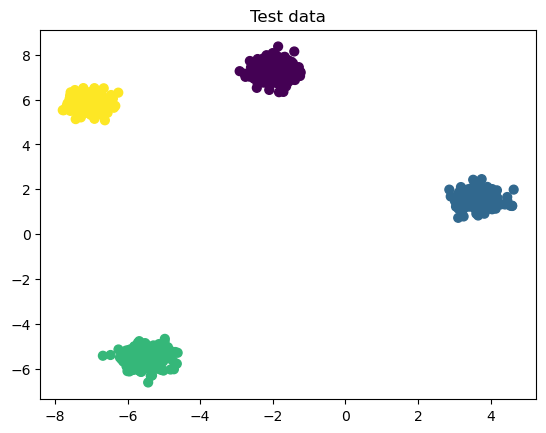

In [3]:
n_clusters = 4
ran_s = 42

#np.random.seed(42)

# Generate artificial dataset
X, y_true = make_blobs(n_samples=7000, centers=4,
                       cluster_std=0.3, random_state=ran_s,
                       center_box=(-8.0, 8.0),
                       shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, train_size=6000, random_state=42)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap='viridis')
plt.title("Training data")

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap='viridis')
plt.title("Test data")

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class DeterministicAnnealing, according to the contract outlined in its docstring. (The template class DeterministicAnnealing is in file <b>DA.py</b> which you can open in your favourite IDE) For the implementation, it may help to take a look at both <b>get_distance method</b> and <b>fit _calculate_cluster_probs method</b> and implement them as well. Of course you are free to change all these methods or/and write additional methods for your purpose.
    You can add more class methods as necessary.
    See http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for complementary information.
</p>
<p style="background-color:#adebad;">
    While implementing, you can run the bloc below to test your implementation.
</p>

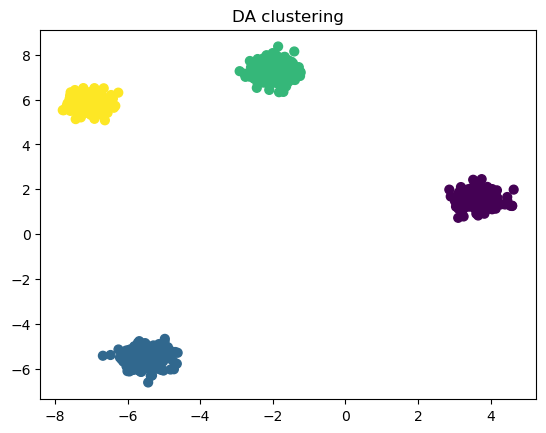

In [4]:
from DA import DeterministicAnnealingClustering

DAC = DeterministicAnnealingClustering(
    n_clusters=n_clusters, random_state=ran_s)
DAC.fit(X_train)
y_DAC = DAC.predict(X_test)
y_DAC_hard = np.argmax(y_DAC, axis=1)
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_DAC_hard, s=40, cmap='viridis')
plt.title("DA clustering")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points. Note that you can have a maximum of 6 points at the end.</span>
</h2>

<p style="background-color:#adebad;">
    In this section we implement a plot which will help us better understand the DA method, and could also be a help for better debugging of your implementation.
    
 <ul style="background-color:#adebad;">
        <li> 
            Modify your implementation of <b>fit</b> function such that <b>plot_phase_diagram</b> method will produce a plot similar to the phase diagram plot shown in Figure 2 of the reference paper.
        </li>
</ul>  
</p>

<ul style="background-color:#adebad;">
            For this, extend DAC.fit to save the expected distortion during annealing as an additional attribute self.distortion.
            You might also want to save the number of effective clusters and the temperature along the way.
    </ul>
</p>

#### extend DAC.fit(self, X):
    # ...
    # Save information for each (n-th) annealing step:
    # self.distortion = [d0, d1, d2, ...]
    # self.n_eff_clusters = [e0, e1, e2, ...]
    # self.temp = [t0, t1, t2, ...]
    # ...

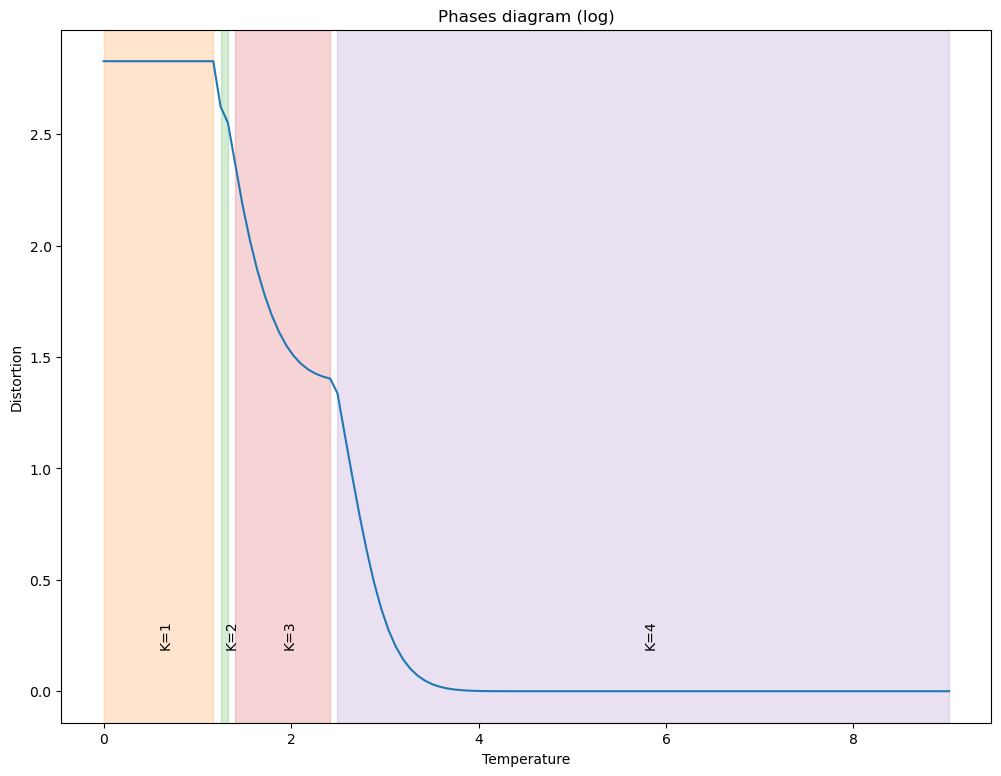

In [5]:
DAC.plot_phase_diagram()

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>
<ul style="background-color:#adebad;">
Here we implement another plot which helps better undetrstad the dynamics of the algorithm.
        <li>
        Implement DAC.plot_bifurcation, which should create a bifurcation plot.<br>
        Modify DAC.fit to keep track of the distances, using the tree object DAC.bifurcation_tree. When a cluster splits, it creates two child nodes. Each node should store its centroid vector, and the distance to the parent centroid vector. After splitting, the parent node is not updated anymore.<br>
        In the bifurcation plot, the horizontal distance of a child node to its parent node should be exactly the distance to the parent centroid vector. The two child nodes should move in opposite directions, i.e. one to the left of the parent and one to the right.
        </li>
</ul>

This section could bit a bit annoying, you can also jump to the next sections and come back here later. 

C:\Users\faran\.ssh\slt-coding-exercises-23\DA.py:338: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(s[:cut_idx], beta[:cut_idx], '-k',


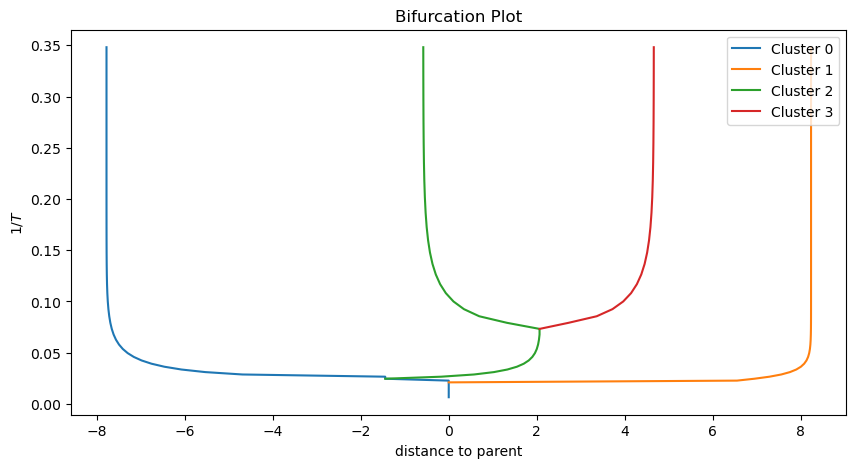

In [6]:
DAC.plot_bifurcation()

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>

<p style="background-color:#adebad;">
Now we are ready to use some real world data. This might need some tweaking and handling of numberical instabilities. Please make sure your understand the data.
</p>

<p style="background-color:#adebad;">
Read the wine data [3], which contains 11 physiochemical attributes, and two labels (quality and color).
</p>

<p style="background-color:#adebad;">
    Create an instance of your DAC class with n_clusters = 2 and <b>fit the first 6000 samples</b> of the wine data set. Record the execution time. Furthermore, create an instance of the sklearn k-means class, and fit it with the same parameters. Again record the execution time. Make sure that the hyper parameters (initial temperature, min temperature, convergence criteria, noise, etc.) make sense and lead to a reasonable clustering
</p>

In [53]:
from DA import read_data_csv
from DA import DeterministicAnnealingClustering

np.random.seed(42)

X, y = read_data_csv("wine-data.csv", y_names=["quality", "color"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y["color"], train_size=6000, random_state=42)

In [54]:
%%time
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42, T_min=200, min_err=1e-3, T_0=1e-4)
DAC.fit(X_train)

CPU times: total: 1min 14s
Wall time: 1min 3s


In [55]:
%%time

kmeans = cluster.KMeans(n_clusters=2,random_state=42)
kmeans.fit(X_train)

CPU times: total: 109 ms
Wall time: 129 ms


C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [56]:
%%time
y_kmeans = kmeans.predict(X_test)

CPU times: total: 0 ns
Wall time: 4.05 ms


In [57]:
%%time
y_DAC = DAC.predict(X_test)

CPU times: total: 0 ns
Wall time: 2.04 ms


The hyperparameters we chose make sense: T_0, i.e. the temperature of the last iteration is very small (it cannot be exactly 0 
as otherwise we would be dividing by 0 in some of the formulas). Also, min_err, which is the convergence threshold we use 
when we calculate the centroids iteratively, is very small, which means we run the iterative procedure almost until convergence.
The only parameter we are not completely satisfied of is T_min, which is slightly high, but we had to use this value as 
otherwise we would have had numerical issues when running the program

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>
<ul style="background-color:#adebad;">
<li> Before we can compute the confusion matrix, we need to perform some post-processing on the DAC cluster assignments.
    Explain what the function postprocess (defined below) does, and why we need it. To do so, complete the docstring of the function postprocess.
        </li>
</ul>

In [58]:
def postprocess(y_DAC, y_kmeans):
    """TODO: Add explanation"""
    
    """Our goal is to compare the two outputs of DAC and K_means (in particlar, y_DAC and y_kmeans) to compare the 
    performance of the two algorithms. In order to do so, however, we need to take into account that clustering 
    depends on the labeling of different clusters and hence we need to find a way to convert labels predicted by DAC to the labels
    predicted by Kmeans. In order to do so, we assign, we map (for every cluster) the label of the most likely datapoint 
    according to DAC to the corresponding label of that particular datapoint according to kmeans. We store this change of labels 
    in dac2kmeans which will then be used to convert all the predictions"""
    
    y_DAC_hard = np.argmax(y_DAC, axis=1)
    
    n_clusters = len(np.unique(y_DAC_hard))
    dac2kmeans = []
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster])
        dac2kmeans.append(y_kmeans[argmax])
        
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label])
        
    return np.array(y_DAC_new)

In [59]:
skl.metrics.confusion_matrix(y_kmeans, postprocess(y_DAC, y_kmeans))

array([[288,   0],
       [ 16, 193]], dtype=int64)

</h2>

<ul style="background-color:#adebad;">
        <li> Read the docstring of <b>transform method</b> and understand what it does.
        </li>
        <li>
        Use DAC.transform and kmeans.transform to transform both, X_train and X_test. 
        </li>
       
</ul>

In [60]:
X_train_DAC = DAC.transform(X_train)
X_test_DAC = DAC.transform(X_test)

X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

<ul style="background-color:#adebad;">
        <li>
        Fit an SVM classifier with default parameters to the untransformed data, and to the transformed data.
        Compare the performance of predicting whether the color of a wine is red or white.
        </li>
    </ul>

In [61]:
svm_1 = svm.SVC(random_state=42) 
svm_1.fit(X_train, y_train.ravel())
svm_1.score(X_test, y_test.ravel())

0.9275653923541247

In [62]:
svm_2 = svm.SVC(random_state=42)
svm_2.fit(X_train_DAC, y_train.ravel())
svm_2.score(X_test_DAC, y_test.ravel())

0.9154929577464789

In [63]:
svm_3=svm.SVC(random_state=42)
svm_3.fit(X_train_kmeans, y_train.ravel())
svm_3.score(X_test_kmeans, y_test.ravel())

0.9134808853118712

<ul style="background-color:#adebad;">
        <li>
        Produce two scatter plots, one for X_train_DAC and one for X_train_kmeans.<br>
        Make the marker color indicate the wine color.
        </li>
    </ul>

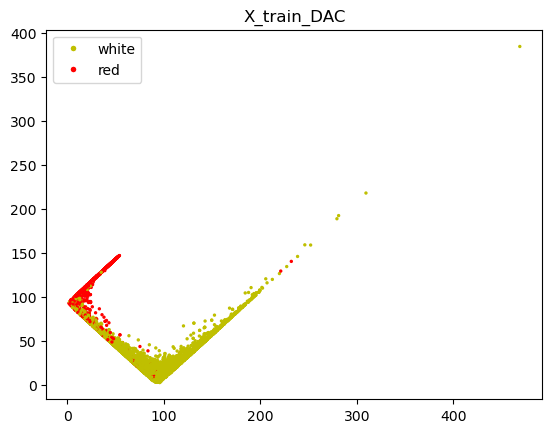

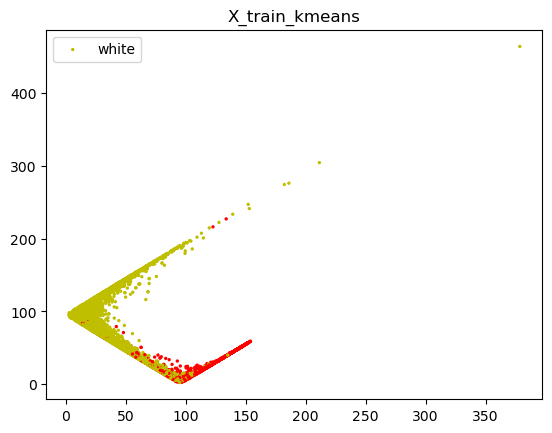

In [64]:
from matplotlib.lines import Line2D

colors=[]
for i in range(len(y_train)):
    if y_train[i]=='white':
        colors.append('y')
    else:
        colors.append('r')

plt.figure()
plt.scatter(X_train_DAC[:, 0], X_train_DAC[:, 1], s=2, c=colors)
plt.title('X_train_DAC')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='y', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='r', markersize=5)]
plt.legend(legend_elements, ['white', 'red'])
plt.show()

plt.figure()
plt.scatter(X_train_kmeans[:, 0], X_train_kmeans[:, 1], s=2, c=colors)
plt.title('X_train_kmeans')
plt.legend(labels= ['white', 'red'])
plt.show()


<ul style="background-color:#adebad;">
    <li>
        Create a fixed 2D embedding (e.g. with LLE, t-SNE, MDS) of the wine data and color the markers according to quality and color. Fit and transform X_train with DAC(n_clusters=2,3,4,5,6,7,8,...). Produce a plot of the SVM score svm_DAC.score(X_test_DAC, y_test) as a function of n_clusters.. Each time use marker shapes to display the cluster memberships, and compare to the labels color and quality.
    </li>
</ul>

<Figure size 640x480 with 0 Axes>

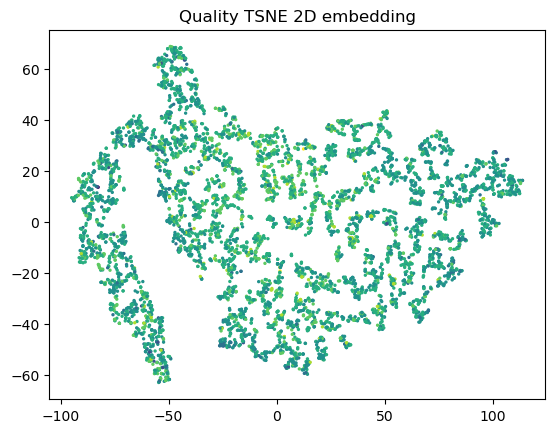

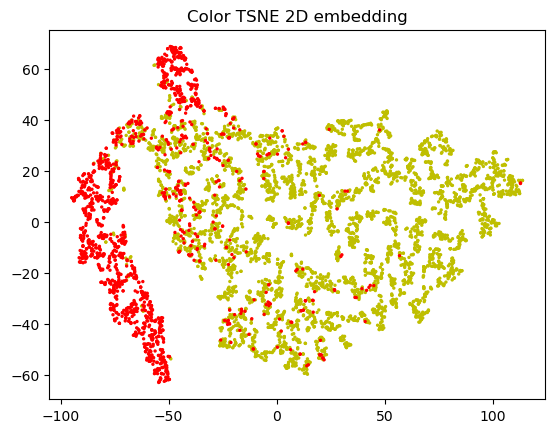

In [65]:
from sklearn.manifold import TSNE

#2D embedding 

embedding=TSNE(n_components=2, random_state=42).fit_transform(X)

# quality embedding

plt.figure()
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, c=y['quality'])
plt.title("Quality TSNE 2D embedding")
plt.show()


#color embedding

colors=[]
for i in range(len(y['color'])):
    if y['color'][i]=='white':
        colors.append('y')
    else:
        colors.append('r')

plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, c=colors)
plt.title("Color TSNE 2D embedding")
plt.show()


Comment: wheh I was looking at the documentation for using TSNE, I noticed that someone mentioned that in some cases it might give different results when run on Windows and Mac. As I am using Windows and I don't know whether you are using Windows or IOS, I kindly ask, in case this images don't correspond to what you have, if you could possibly run this cell (and the one below) on your laptop to verify if effectively this gives a different result or it is just an operating system issue. Thanks in advance!
    

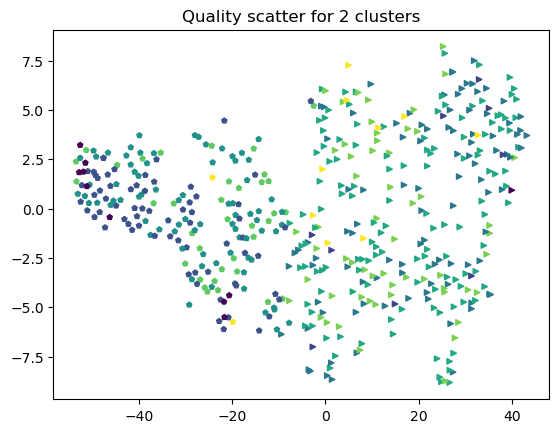

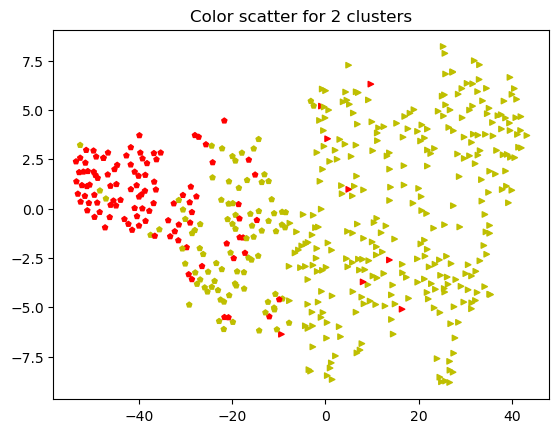

C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


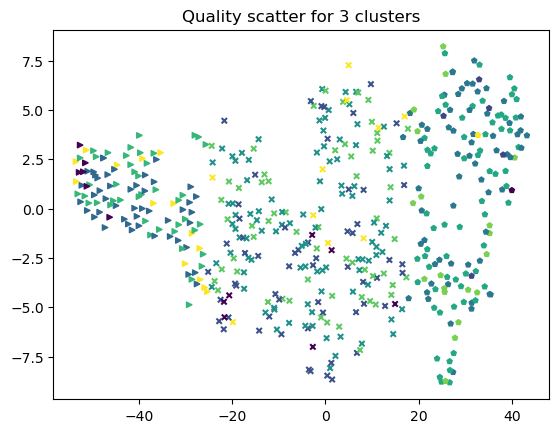

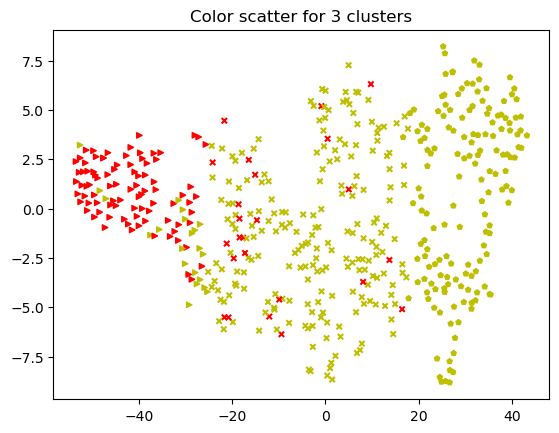

C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


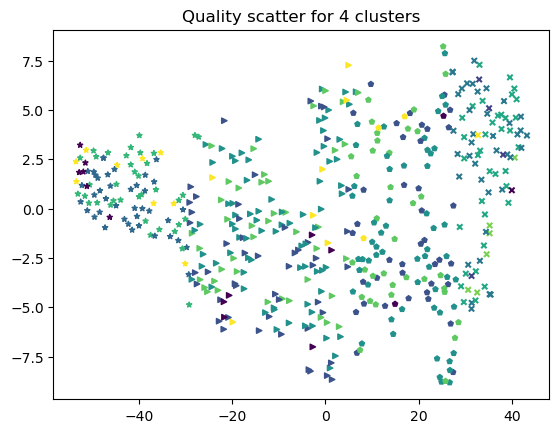

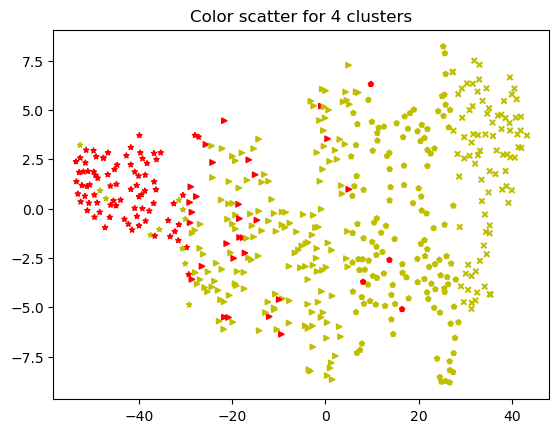

C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


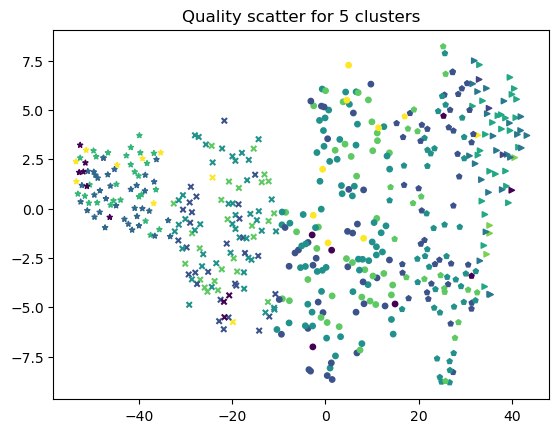

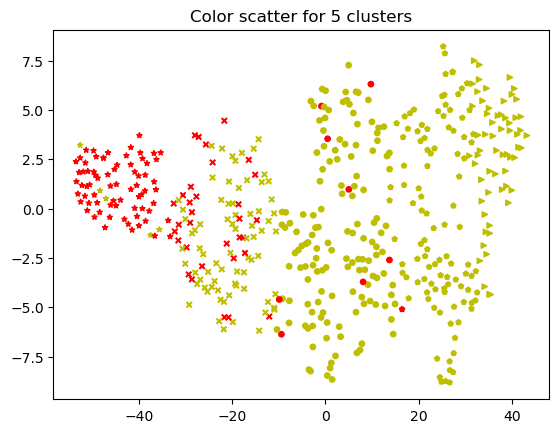

C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


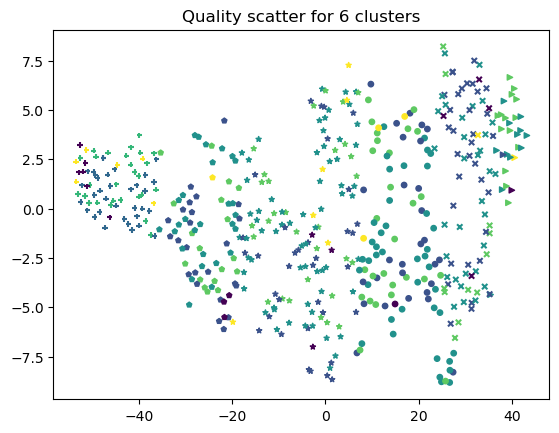

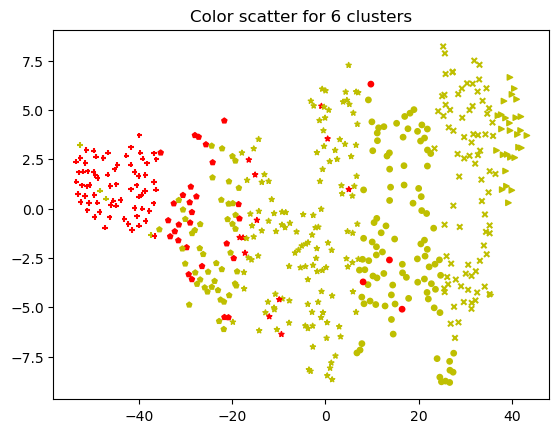

C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


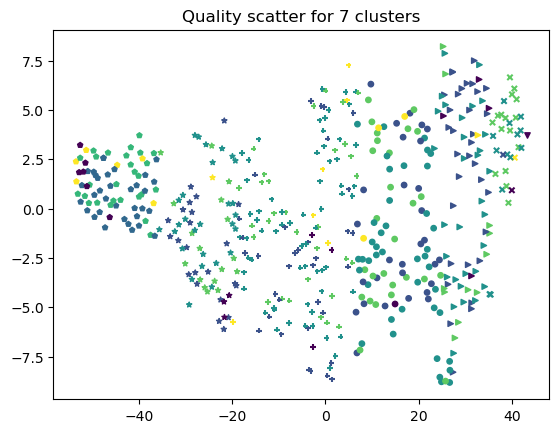

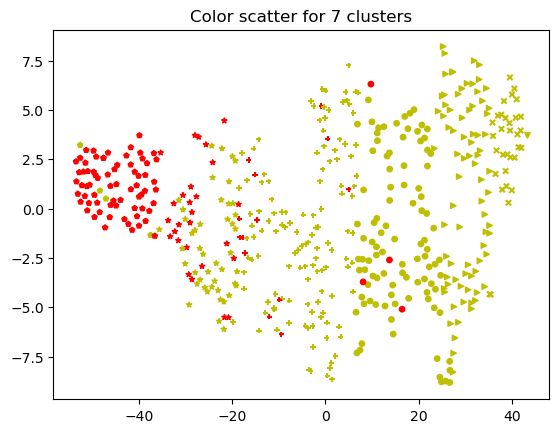

C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


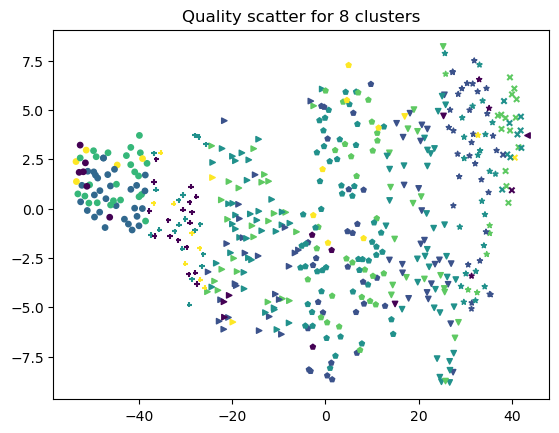

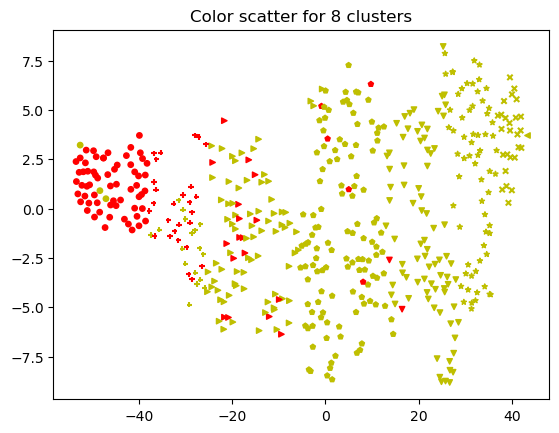

C:\Users\faran\anaconda3\envs\slt-ce\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


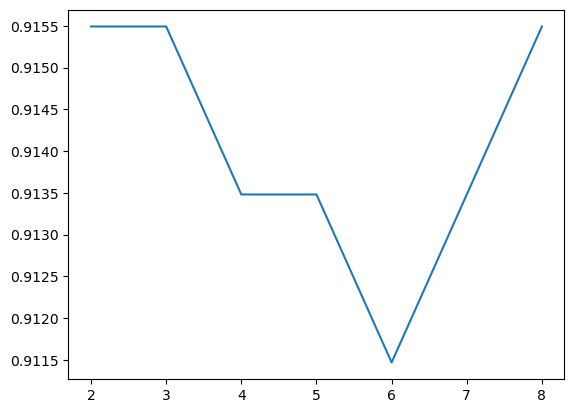

In [70]:
# fit and transform X_train with DAC for different clusters

markers=['x', '*', 'o', '+', 'v', '<', '>', 'p']
svm_scores=[]
num_clusters=np.arange(2,9)

X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X, y["quality"], train_size=6000, random_state=42)

test_embedding=TSNE(n_components=2, random_state=42).fit_transform(X_test)

for i in num_clusters:
    
    DAC=DeterministicAnnealingClustering(n_clusters=i, random_state=42, T_min=200, min_err=1e-3, T_0=1e-4)
    DAC.fit(X_train)
    X_train_DAC=DAC.transform(X_train)
    X_test_DAC=DAC.transform(X_test)
    
    Y_test_probs=DAC.predict(X_test)
    Y_pred=np.argmax(Y_test_probs, axis=1)
    
    marker_assignments=np.zeros(X_test.shape[0])
    
    plt.figure()
    for j in range(i):
        
        plt.scatter(test_embedding[Y_pred==j, 0], test_embedding[Y_pred==j, 1], s=15, c=y_test_q[Y_pred==j], marker=markers[j-2])
    
    plt.title("Quality scatter for " +str(i) + " clusters")
    plt.show()


    

    colors=[]
    for k in range(len(y_test)):
        if y_test[k]=='white':
            colors.append('y')
        else:
            colors.append('r')
            
    colors=np.array(colors)
    
    plt.figure()
    for j in range(i):
        plt.scatter(test_embedding[Y_pred==j, 0], test_embedding[Y_pred==j, 1], s=15, c=colors[Y_pred==j], marker=markers[j-2])
    plt.title("Color scatter for " + str(i) + " clusters")
    plt.show()

    
    
    
    #build SVM and calulate score
    svm_DAC=svm.SVC(random_state=0)
    svm_DAC.fit(X_train_DAC, y_train)
    current_score = svm_DAC.score(X_test_DAC, y_test)
    svm_scores.append(current_score)
    
    
plt.plot(num_clusters, svm_scores) #plot svm scores as a function of number of clusters

<ul style="background-color:#adebad;">
        <li>
            So far, our implementation of DAC assumed that our data is compatible with the euclidian metric. Argue why this assumption is not justified for the wine-data. Suggest a better alternative (no implementation required!).
        </li>
    </ul>
</p>



From the two dimensional embeddings that we created and from the transformation thanks to DAC, we can see that 
the data more or less lie on a two dimensional (non affine) manifold. Hence, the notion of distance would need to be adapted to the manifold itself. Many approaches have been proposed to estimate distances on manifolds, one of them is ISOMAP for example, where a graph is embedded in space and distances are calculated between neighboring points. In this setting, one common possibility is choosing a kernel (often the RBF kernel) to calculate distances between neighboring points. In particular, we only keep distances that are above a certain threshold (i.e. we keep points that are close to the point we are analyzing). The intuition behind this is that, in a neighborhood of the point we are considering, we can approximate the distances between points which lie in the neighborhood (which would formally be given by geodesics) with classical distances that we usually adopt when dealing with Euclidean geometry. The RBF kernel automatically only selects points that are closeby the point we are analyzing since it decays exponentially.